# DJF_ts_teleconnection: 

## Datasets Used for SSTA Comparison
The following reference datasets are employed to evaluate the ENSO-related SST patterns in model simulations:

- **TropFlux** (1979–2018): The primary dataset for comparison, providing high-quality estimates of surface fluxes and anomalies designed for tropical ocean and climate studies, combining in-situ measurements with satellite-derived data.
Additional datasets include:

- **20CRv2** (1871–2012): A century-scale reanalysis leveraging surface pressure observations to reconstruct global atmospheric conditions.- **ERA-Interim** (1979–2018): A widely used reanalysis dataset offering high-resolution estimates of atmospheric and surface variables with robust data assimilation techniques.
- **ERSSTv5** (1854–2018): A globally gridded dataset of historical SSTs derived from in-situ measurements and optimised for climate monitoring and ENSO studies.
- **HadISST** (1870–2018): A long-term SST and sea ice dataset combining ship and buoy observations with historical data reconstruction.
- **NCEP2** (1979–2018): The second-generation reanalysis dataset from NCEP, improving upon the earlier version for global atmospheric and oceanic variability analysis.

In [1]:
from esmvalcore.dataset import Dataset

from esmvalcore.config import CFG
CFG['rootpath']['OBS6'].append(r'/g/data/kj13/datasets/esmvaltool/obsdata-v2') #NCEP-DOE-R2 tos

In [5]:
model_datasets = {
"ACCESS-ESM1-5": 
    Dataset(
    short_name='ts',
    project='CMIP6',
    mip="Amon",
    exp="historical",
    ensemble="r1i1p1f1",
    timerange="19790101/20190101",
    dataset="ACCESS-ESM1-5",
    grid="gn"
)}

obs_datasets = {
"NCEP-DOE-R2": #nan data
    Dataset(
    short_name='tos',
    dataset='NCEP-DOE-R2',
    mip="Amon",
    project='OBS6',
    type='reanaly',
    tier=2),
# "HadISST": 
#     Dataset(
#     short_name='tos',
#     dataset='HadISST',
#     mip="Omon",
#     project='OBS',
#     type='reanaly',
#     tier=2),
"ERA-Interim":
    Dataset(
    short_name='ts',
    dataset='ERA-Interim',
    mip="Amon",
    project='OBS6',
    type='reanaly',
    tier=3)
}

## Add Ancillary files


In [6]:
for name, dataset in model_datasets.items():
    dataset.add_supplementary(short_name='sftlf', mip="fx")
    dataset.add_supplementary(short_name="areacella", mip="fx")

In [11]:
model_datasets = {name: dataset.load() for name, dataset in model_datasets.items()}
obs_datasets = {name: dataset.load() for name, dataset in obs_datasets.items()}

(for file /g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r1i1p1f1/fx/sftlf/gn/v20191115/sftlf_fx_ACCESS-ESM1-5_historical_r1i1p1f1_gn.nc)


In [12]:
from esmvalcore.preprocessor import anomalies
from esmvalcore.preprocessor import area_statistics
from esmvalcore.preprocessor import seasonal_statistics
from esmvalcore.preprocessor import rolling_window_statistics
from esmvalcore.preprocessor import convert_units
from esmvalcore.preprocessor import extract_region
from esmvalcore.preprocessor import extract_season
from esmvalcore.preprocessor import extract_month
from esmvalcore.preprocessor import detrend
from esmvalcore.preprocessor import regrid
from esmvalcore.preprocessor import detrend
from esmvalcore.preprocessor import mask_landsea
from esmvalcore.preprocessor import extract_time
import iris

import matplotlib.pyplot as plt
import iris.quickplot as qplt
import numpy as np
import scipy.stats

In [13]:
def sst_enso(cube):
    nino34_latext_region = {"start_longitude": 190., "end_longitude": 240., "start_latitude": -5., "end_latitude": 5.}
    cube = extract_time(cube, start_year=1979, end_year=2000, start_month=12, end_month=3, start_day=1, end_day=31)
    cube = regrid(cube, target_grid="1x1", scheme="linear")
    cube = convert_units(cube, units="degC")
    cube = mask_landsea(cube, mask_out="land") #shp or land fraction
    cube = detrend(cube, dimension="time", method="linear")
    cube = extract_region(cube, **nino34_latext_region)
    cube = area_statistics(cube,operator='mean')
    cube = extract_season(cube, season="DJF")
    # cube = seasonal_statistics(cube, operator='mean') #
    cube = anomalies(cube, period="full")
    return cube


def sst_global(cube):
    region = {"start_longitude": 0., "end_longitude": 360., "start_latitude": -60., "end_latitude": 60.}
    # DJF season - start in dec
    cube = extract_time(cube, start_year=1979, end_year=2000, start_month=12, end_month=3, start_day=1, end_day=31)
    cube = regrid(cube, target_grid="1x1", scheme="linear")
    cube = convert_units(cube, units="degC")

    #cube = detrend(cube, dimension="time", method="linear") # Create NaN for some reasons
    cube = extract_season(cube, season="DJF")
    # cube = seasonal_statistics(cube, operator='mean')
    cube = anomalies(cube, period="full")
    cube = extract_region(cube, **region)
    return cube   

In [14]:
model_tos_datasets_prep = {name: sst_enso(dataset) for name, dataset in model_datasets.items()}
model_glb_datasets_prep = {name: sst_global(dataset) for name, dataset in model_datasets.items()}

obs_tos_datasets_prep = {name: sst_enso(dataset) for name, dataset in obs_datasets.items()}
obs_glb_datasets_prep = {name: sst_global(dataset) for name, dataset in obs_datasets.items()}

/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/iris/coords.py:2164: IrisVagueMetadataWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'time'.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/iris/coords.py:2153: IrisVagueMetadataWarning: Cannot check if coordinate is contiguous: Invalid operation for 'season_year', with 0 bound(s). Contiguous bounds are only defined for 1D coordinates with 2 bounds. Metadata may not be fully descriptive for 'season_year'. Ignoring bounds.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/iris/coords.py:2164: IrisVagueMetadataWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'time'.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/iris/coords.py:2153: IrisVagueMetadataWarning: Cannot

## Calculate Linear regression

In [15]:
def lin_regress_matrix(cubeA, cubeB): #array must not contain infs or NaNs
    """
    Calculate the linear regression of cubeA on cubeB using matrix operations.

    Parameters
    ----------
    cubeA: iris.cube.Cube
        The 2D input cube for which the regression is calculated.
    
    cubeB: iris.cube.Cube
        The cube used as the independent variable in the regression.

    Returns
    -------
    iris.cube.Cube
        A new cube containing the slope of the regression for each spatial point.
    """
    # Get data as flattened arrays
    A_data = cubeA.data.reshape(cubeA.shape[0], -1)  # Shape (time, spatial_points)
    B_data = cubeB.data.flatten()  # Shape (time,)

    # Add intercept term by stacking a column of ones with cubeB
    B_with_intercept = np.vstack([B_data, np.ones_like(B_data)]).T

    # Solve the linear equations using least squares method
    coefs, _, _, _ = np.linalg.lstsq(B_with_intercept, A_data, rcond=None)
    
    # Extract slopes from coefficients #coefs 1
    slopes = coefs[0].reshape(cubeA.shape[1], cubeA.shape[2])

    # Create a new Iris Cube for the regression results
    result_cube = iris.cube.Cube(slopes, long_name='regression ENSO SSTA',
                                 dim_coords_and_dims=[(cubeA.coord('latitude'), 0),
                                                      (cubeA.coord('longitude'), 1)])

    return result_cube

In [16]:
#create shapely geometry from lat/lon..
from shapely import box
import numpy as np
import shapely.vectorized as shp_vect

# cube = reg2_mod
# Create a set of x,y points from the cube
def mask_pacific(cube):
    region = box(130.,-15.,270.,15) #remove land
    x_p, y_p = np.meshgrid(
        cube.coord(axis="X").points,
        cube.coord(axis="Y").points,
    )

    mask = shp_vect.contains(region, x_p, y_p)
    cube.data.mask = mask
    return cube

In [18]:
reg2_mod = lin_regress_matrix(model_glb_datasets_prep["ACCESS-ESM1-5"], model_tos_datasets_prep["ACCESS-ESM1-5"])
reg2_obs = lin_regress_matrix(obs_glb_datasets_prep["ERA-Interim"], obs_tos_datasets_prep["ERA-Interim"]) #

reg2_obs = mask_pacific(reg2_obs)
reg2_mod = mask_pacific(reg2_mod)
process = {"ACCESS-ESM1-5":reg2_mod , "ERA-Interim":reg2_obs} 

# Diagnostic Level 1

In [19]:
rmse = np.sqrt(np.mean((reg2_obs.data- reg2_mod.data) ** 2))
print(rmse) # before mask 0.3 (-0.9469973, 2.0757544, -1.1118968, 1.3990197, 0.07520806)

reg2_mod.data.min(), reg2_mod.data.max(), reg2_obs.data.min(), reg2_obs.data.max(), reg2_obs.data.mean()

0.31090157109454186


(-0.9469973, 2.0757544, -1.1118966, 1.3990196, 0.052649432842548076)

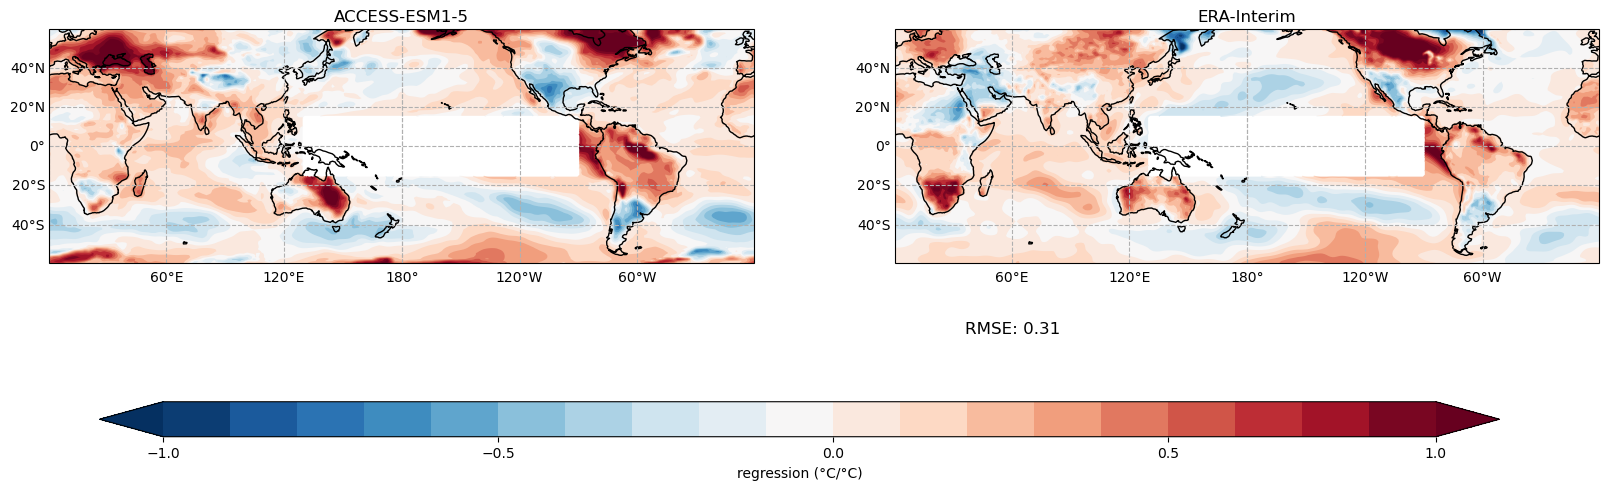

In [20]:
import iris.plot as iplt
import matplotlib.colors as mcolors
import cartopy.feature as cfeature
import cartopy.crs as ccrs

fig = plt.figure(figsize=(20, 7))
proj = ccrs.PlateCarree(central_longitude=180)

i =121

for label, cube in process.items():
    
    ax1 = plt.subplot(i,projection=proj)
    ax1.coastlines()
    cf1 = iplt.contourf(cube, levels=np.arange(-1,1,0.1), extend='both',cmap='RdBu_r')
    ax1.set_title(label)
    gl1 = ax1.gridlines(draw_labels=True, linestyle='--')
    gl1.top_labels = False
    gl1.right_labels = False
    i+=1


plt.text(0.1, -0.3, f'RMSE: {rmse:.2f} ', fontsize=12, ha='left',
         transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

# Add a single colorbar at the bottom
cax = plt.axes([0.15,0.08,0.7,0.05])
cbar = fig.colorbar(cf1, cax=cax, orientation='horizontal', extend='both', ticks=np.arange(-1,1.5,0.5))
cbar.set_label('regression (°C/°C)')